# Classification of ECG Diagnoses

Original Benchmarking Paper: &nbsp; [Deep Learning for ECG Analysis: Benchmarks and Insights from PTB-XL](https://ieeexplore.ieee.org/document/9190034)

Original Repository from Paper: &nbsp; [Repository on GitHub](https://github.com/helme/ecg_ptbxl_benchmarking)

Dataset: &nbsp; [PTB-XL, a large publicly available electrocardiography dataset](https://physionet.org/content/ptb-xl/1.0.3/)

# Import

In [120]:
import sys
import os
import tqdm
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
import torch
import fastai
import wfdb
import pickle

from models.fastai_model import fastai_model

from IPython.display import Image
from tabulate import tabulate

# Utils from original repository

## Preprocessing

In [121]:
def load_raw_data_ptbxl(df, sampling_rate, path):
    if sampling_rate == 100:
        if os.path.exists(path + 'raw100.npy'):
            data = np.load(path+'raw100.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw100.npy', 'wb'), protocol=4)
    elif sampling_rate == 500:
        if os.path.exists(path + 'raw500.npy'):
            data = np.load(path+'raw500.npy', allow_pickle=True)
        else:
            data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_hr)]
            data = np.array([signal for signal, meta in data])
            pickle.dump(data, open(path+'raw500.npy', 'wb'), protocol=4)
    return data

In [122]:
def load_dataset(path, sampling_rate, release=False):

    if path.split('/')[-2] == 'ptbxl':
        # load and convert annotation data
        Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
        print(f"Loaded {len(Y)} samples from PTB-XL dataset.")
        display(Y)

        # Load raw signal data
        X = load_raw_data_ptbxl(Y, sampling_rate, path)
        print(f'\nLoaded {X.shape[0]} samples with shape {X.shape[1:]} from PTB-XL dataset.')
        display(X)

    return X, Y

In [123]:
def compute_label_aggregations(df, folder, ctype):

    df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))

    # Load scp_statements.csv for diagnostic aggregation
    aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
    diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]

    # --- DIAGNOSTIC ---
    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:
        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    # ------------------

    # --- FORM ---
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    # ------------

    # --- RHYTHM ---
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
   # ------------

    # --- ALL ---
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))
    # -----------

    return df

In [124]:
def select_data(XX: pd.DataFrame, YY: pd.DataFrame, ctype: str,
                min_samples: int = 0, outputfolder: str = '') -> tuple:
    '''
    Select relevant data based on the specified ctype and minimum sample count.

    :param XX: DataFrame containing the ECG signals.
    :dtype XX: pd.DataFrame

    :param YY: DataFrame containing the labels.
    :dtype YY: pd.DataFrame

    :param ctype: Type of classification ('diagnostic', 'subdiagnostic', 'superdiagnostic', 'form', 'rhythm', 'all').
    :dtype ctype: str

    :param min_samples: Minimum number of samples required for a label to be included. Improve model training stability by focusing on labels with sufficient data.
    :dtype min_samples: int

    :param outputfolder: Folder to save the MultiLabelBinarizer.
    :dtype outputfolder: str

    :return: Tuple containing the selected data (X), labels (Y), multi-hot encoded labels (y), and the fitted MultiLabelBinarizer (mlb).
    '''
    # convert multilabel to multi-hot
    mlb = sklearn.preprocessing.MultiLabelBinarizer()

    if ctype == 'diagnostic':
        X = XX[YY.diagnostic_len > 0]
        Y = YY[YY.diagnostic_len > 0]
        mlb.fit(Y.diagnostic.values)
        y = mlb.transform(Y.diagnostic.values)
    elif ctype == 'subdiagnostic':
        counts = pd.Series(np.concatenate(YY.subdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.subdiagnostic = YY.subdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['subdiagnostic_len'] = YY.subdiagnostic.apply(lambda x: len(x))
        X = XX[YY.subdiagnostic_len > 0]
        Y = YY[YY.subdiagnostic_len > 0]
        mlb.fit(Y.subdiagnostic.values)
        y = mlb.transform(Y.subdiagnostic.values)
    elif ctype == 'superdiagnostic':
        counts = pd.Series(np.concatenate(YY.superdiagnostic.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.superdiagnostic = YY.superdiagnostic.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['superdiagnostic_len'] = YY.superdiagnostic.apply(lambda x: len(x))
        X = XX[YY.superdiagnostic_len > 0]
        Y = YY[YY.superdiagnostic_len > 0]
        mlb.fit(Y.superdiagnostic.values)
        y = mlb.transform(Y.superdiagnostic.values)
    elif ctype == 'form':
        # filter
        counts = pd.Series(np.concatenate(YY.form.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.form = YY.form.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['form_len'] = YY.form.apply(lambda x: len(x))
        # select
        X = XX[YY.form_len > 0]
        Y = YY[YY.form_len > 0]
        mlb.fit(Y.form.values)
        y = mlb.transform(Y.form.values)
    elif ctype == 'rhythm':
        # filter 
        counts = pd.Series(np.concatenate(YY.rhythm.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.rhythm = YY.rhythm.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['rhythm_len'] = YY.rhythm.apply(lambda x: len(x))
        # select
        X = XX[YY.rhythm_len > 0]
        Y = YY[YY.rhythm_len > 0]
        mlb.fit(Y.rhythm.values)
        y = mlb.transform(Y.rhythm.values)
    elif ctype == 'all':
        # filter 
        counts = pd.Series(np.concatenate(YY.all_scp.values)).value_counts()
        counts = counts[counts > min_samples]
        YY.all_scp = YY.all_scp.apply(lambda x: list(set(x).intersection(set(counts.index.values))))
        YY['all_scp_len'] = YY.all_scp.apply(lambda x: len(x))
        # select
        X = XX[YY.all_scp_len > 0]
        Y = YY[YY.all_scp_len > 0]
        mlb.fit(Y.all_scp.values)
        y = mlb.transform(Y.all_scp.values)
    else:
        pass

    # save LabelBinarizer
    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)

    return X, Y, y, mlb

In [125]:
def apply_standardizer(X, ss):
    '''
    Apply the standard scaler to each sample in X.

    :param X: Input data, where each sample is a 1D array.
    :dtype X: np.ndarray

    :param ss: StandardScaler fitted on the training data.
    :dtype ss: sklearn.preprocessing.StandardScaler

    :return: Standardized data with the same shape as X.
    '''
    X_tmp = []
    for x in X:
        x_shape = x.shape
        X_tmp.append(ss.transform(x.flatten()[:,np.newaxis]).reshape(x_shape))
    X_tmp = np.array(X_tmp)
    return X_tmp

## Evaluation

In [126]:
def apply_thresholds(preds, thresholds):
	"""
		apply class-wise thresholds to prediction score in order to get binary format.
		BUT: if no score is above threshold, pick maximum. This is needed due to metric issues.
	"""
	tmp = []
	for p in preds:
		tmp_p = (p > thresholds).astype(int)
		if np.sum(tmp_p) == 0:
			tmp_p[np.argmax(p)] = 1
		tmp.append(tmp_p)
	tmp = np.array(tmp)
	return tmp

In [127]:
def challenge_metrics(y_true, y_pred, beta1=2, beta2=2, class_weights=None, single=False):
    f_beta = 0
    g_beta = 0
    if single: # if evaluating single class in case of threshold-optimization
        sample_weights = np.ones(y_true.sum(axis=1).shape)
    else:
        sample_weights = y_true.sum(axis=1)
    for classi in range(y_true.shape[1]):
        y_truei, y_predi = y_true[:,classi], y_pred[:,classi]
        TP, FP, TN, FN = 0.,0.,0.,0.
        for i in range(len(y_predi)):
            sample_weight = sample_weights[i]
            if y_truei[i]==y_predi[i]==1: 
                TP += 1./sample_weight
            if ((y_predi[i]==1) and (y_truei[i]!=y_predi[i])): 
                FP += 1./sample_weight
            if y_truei[i]==y_predi[i]==0: 
                TN += 1./sample_weight
            if ((y_predi[i]==0) and (y_truei[i]!=y_predi[i])): 
                FN += 1./sample_weight 
        f_beta_i = ((1+beta1**2)*TP)/((1+beta1**2)*TP + FP + (beta1**2)*FN)
        g_beta_i = (TP)/(TP+FP+beta2*FN)

        f_beta += f_beta_i
        g_beta += g_beta_i

    return {'F_beta_macro':f_beta/y_true.shape[1], 'G_beta_macro':g_beta/y_true.shape[1]}

In [128]:
def evaluate_experiment(y_true, y_pred, thresholds=None):
    results = {}

    if not thresholds is None:
        # binary predictions
        y_pred_binary = apply_thresholds(y_pred, thresholds)
        # PhysioNet/CinC Challenges metrics
        challenge_scores = challenge_metrics(y_true, y_pred_binary, beta1=2, beta2=2)
        results['F_beta_macro'] = challenge_scores['F_beta_macro']
        results['G_beta_macro'] = challenge_scores['G_beta_macro']

    # label based metric
    results['macro_auc'] = roc_auc_score(y_true, y_pred, average='macro')
    
    df_result = pd.DataFrame(results, index=[0])
    return df_result

# Preprocessing

Before finetuning a pretrained model of the experiments we provide in our repository (or precomputed and provided [here](https://datacloud.hhi.fraunhofer.de/nextcloud/s/NCjYws3mamLrkKq)), first load your custom 100 Hz sampled 12-lead ECG signal data `X` of shape `[N,L,12]` in Millivolts (mV) and multi-hot encoded labels `y` of shape `[N,C]` as numpy arrays, where `C` is the number of classes and `N` the number of total samples in this dataset. Although PTB-XL comes with fixed `L=1000` (i,e. 10 seconds), it is not required to be fixed, **BUT** the shortest sample must be longer than `input_size` of the specific model (e.g. 2.5 seconds for our fastai-models).

For proper tinetuning split your data into four numpy arrays: `X_train`,`y_train`,`X_val` and `y_val`

Example: finetune model trained on all (71) on superdiagnostic (5)


Below we provide an example for loading [PTB-XL](https://physionet.org/content/ptb-xl/1.0.1/) aggregated at the `superdiagnostic` level, where we use the provided folds for train-validation-split:

## SCP-ECG acronym decriptions for super and subclasses

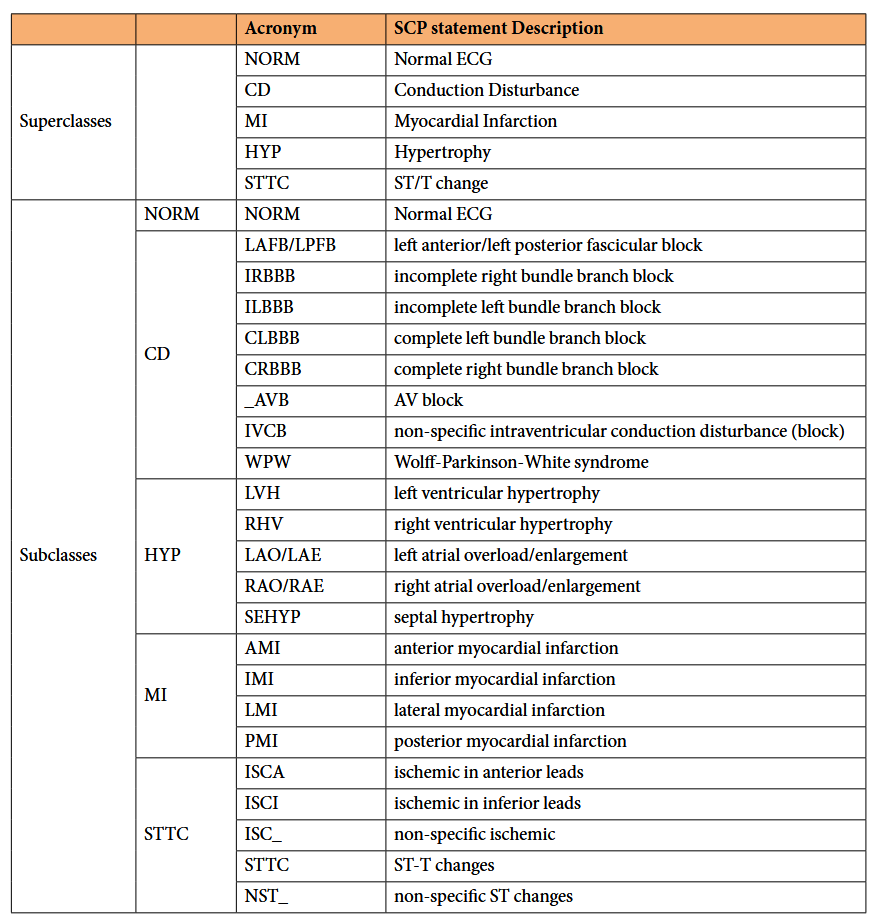

In [129]:
path = "../img/scp_acronym_decription.png"
Image(filename = path, width=500)

## Load and aggregate data

In [130]:
sampling_frequency=100
datafolder='../../data/ptbxl/'
task='subdiagnostic'
outputfolder='../output/'

# Load PTB-XL data
df, raw_labels = load_dataset(datafolder, sampling_frequency)

# Preprocess label data
labels = compute_label_aggregations(raw_labels, datafolder, task)

# Select relevant data and convert to one-hot
X, Y, y, mlb = select_data(df, labels, task, min_samples=0, outputfolder=outputfolder)

# display dataframe, containing Y, and X below

Loaded 21799 samples from PTB-XL dataset.


,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr



Loaded 21799 samples with shape (1000, 12) from PTB-XL dataset.


array([[[-1.190e-01, -5.500e-02,  6.400e-02,  8.600e-02, ...,  0.000e+00, -2.600e-02, -3.900e-02, -7.900e-02],
        [-1.160e-01, -5.100e-02,  6.500e-02,  8.300e-02, ..., -3.000e-03, -3.100e-02, -3.400e-02, -7.400e-02],
        [-1.200e-01, -4.400e-02,  7.600e-02,  8.200e-02, ..., -1.000e-02, -2.800e-02, -2.900e-02, -6.900e-02],
        [-1.170e-01, -3.800e-02,  8.000e-02,  7.700e-02, ..., -1.500e-02, -2.300e-02, -2.200e-02, -6.400e-02],
        ...,
        [ 9.000e-02,  2.100e-02, -6.900e-02, -5.500e-02, ..., -2.300e-02, -2.700e-02, -3.600e-02, -8.000e-03],
        [ 6.900e-02,  0.000e+00, -6.900e-02, -3.400e-02, ...,  0.000e+00,  2.400e-02, -4.100e-02, -5.800e-02],
        [ 8.600e-02,  4.000e-03, -8.100e-02, -4.400e-02, ..., -2.500e-02,  2.420e-01, -4.600e-02, -9.800e-02],
        [ 2.200e-02, -3.100e-02, -5.400e-02,  5.000e-03, ..., -1.490e-01,  1.430e-01, -3.500e-02, -1.200e-01]],

       [[ 4.000e-03,  1.380e-01,  1.340e-01, -7.200e-02, ...,  1.430e-01,  1.920e-01,  8.300e-02,

## Check double labels

In [131]:
# check combinations where AMI and IMI are present in diagnostic in Y
Y_check = Y[
    (Y.subdiagnostic.apply(lambda x: 'AMI' in x)) &
    (Y.subdiagnostic.apply(lambda x: 'IMI' in x))
]

Y_check[['scp_codes', 'subdiagnostic']]

,scp_codes,subdiagnostic
ecg_id,,
181,"{'ASMI': 100.0, 'ALMI': 100.0, 'IMI': 15.0, 'A...","[AMI, IMI, STTC]"
184,"{'ILMI': 100.0, 'ASMI': 100.0, 'SR': 0.0}","[AMI, IMI]"
189,"{'ASMI': 100.0, 'ILMI': 100.0, 'SR': 0.0}","[AMI, IMI]"
234,"{'ASMI': 100.0, 'IMI': 15.0, 'ANEUR': 100.0, '...","[AMI, _AVB, IMI, STTC]"
257,"{'ASMI': 50.0, 'IMI': 100.0, 'PAC': 0.0, 'LOWT...","[AMI, IMI]"
...,...,...
21654,"{'ASMI': 100.0, 'ILMI': 15.0, 'LPFB': 100.0, '...","[AMI, IMI, LAFB/LPFB]"
21658,"{'ALMI': 100.0, 'IPMI': 100.0, 'ABQRS': 0.0, '...","[AMI, IMI]"
21716,"{'AMI': 15.0, 'IMI': 15.0, 'SR': 0.0}","[AMI, IMI]"


## Refactor classes for prediction

In [145]:
all_class_names = list(mlb.classes_)
all_class_ids = [i for i, name in enumerate(all_class_names)]
num_all_classes = len(all_class_names)

print(f"All classes: {all_class_names}")
print(f'Class IDs: {all_class_ids}')
print(f"Count classes: {num_all_classes}")

All classes: ['AMI', 'CLBBB', 'CRBBB', 'ILBBB', 'IMI', 'IRBBB', 'ISCA', 'ISCI', 'ISC_', 'IVCD', 'LAFB/LPFB', 'LAO/LAE', 'LMI', 'LVH', 'NORM', 'NST_', 'PMI', 'RAO/RAE', 'RVH', 'SEHYP', 'STTC', 'WPW', '_AVB']
Class IDs: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
Count classes: 23


In [146]:
# extract excisting classes
#classes = ['AMI', 'IMI', 'NORM']
classes = ['IMI', 'NORM']
class_ids = [i for i, name in enumerate(all_class_names) if name in classes]
num_classes = len(classes)

print(f"All classes: {classes}")
print(f'Class IDs: {class_ids}')
print(f"Count classes: {num_classes}")

All classes: ['IMI', 'NORM']
Class IDs: [4, 14]
Count classes: 2


In [147]:
# add new class
new_classes = classes + ['OTHER']
other_id = num_classes # ids start at zero, so we can use num_classes directly
new_class_ids = class_ids + [other_id]
num_new_classes = len(new_classes)


print(f"Classes: {new_classes}")
print(f'Original Class IDs: {new_class_ids}')
print(f"Count classes: {num_new_classes}")

Classes: ['IMI', 'NORM', 'OTHER']
Original Class IDs: [4, 14, 2]
Count classes: 3


In [148]:
# label matrix containing zeros
y_new = np.zeros((y.shape[0], num_new_classes))

# fill new label matrix with existing classes
# [0, 1, 2] is used to fill the matrix first
for i, class_id in enumerate(class_ids):
    y_new[:, i] = y[:, class_id]

display(y_new)

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [149]:
# true when at least one target class is present, false otherwise
target_mask = y[:, class_ids].sum(axis=1) > 0

# true when at least one label is present, false otherwise
any_label_mask = y.sum(axis=1) > 0

# fill new class with 1s where target classes are present
other_mask = (~target_mask) & any_label_mask

# set OTHER label to 1 where target classes are not present
y_new[other_mask, other_id] = 1

print(y_new)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [150]:
print("Distribution of old labels:")

percentage_all_samples = 0
for i, class_name in enumerate(all_class_names):
    count = (y[:, i] == 1).sum()
    percentage = count / y.shape[0] * 100 if y.shape[0] > 0 else 0
    percentage_all_samples += percentage
    print(f"{class_name}: {count} Samples ({percentage:.1f}%)")

print(f'∑ Samples: {y_new.shape[0]} ({percentage_all_samples})%')
print(f"\nSamples without any label: {(y_new.sum(axis=1) == 0).sum():.1f}")

Distribution of old labels:
AMI: 3078 Samples (14.4%)
CLBBB: 536 Samples (2.5%)
CRBBB: 541 Samples (2.5%)
ILBBB: 77 Samples (0.4%)
IMI: 3271 Samples (15.3%)
IRBBB: 1118 Samples (5.2%)
ISCA: 941 Samples (4.4%)
ISCI: 397 Samples (1.9%)
ISC_: 1272 Samples (5.9%)
IVCD: 787 Samples (3.7%)
LAFB/LPFB: 1797 Samples (8.4%)
LAO/LAE: 426 Samples (2.0%)
LMI: 201 Samples (0.9%)
LVH: 2132 Samples (10.0%)
NORM: 9514 Samples (44.5%)
NST_: 767 Samples (3.6%)
PMI: 17 Samples (0.1%)
RAO/RAE: 99 Samples (0.5%)
RVH: 126 Samples (0.6%)
SEHYP: 29 Samples (0.1%)
STTC: 2239 Samples (10.5%)
WPW: 79 Samples (0.4%)
_AVB: 823 Samples (3.8%)
∑ Samples: 21388 (141.51393304656818)%

Samples without any label: 0.0


In [151]:
print(f"\nDistribution of new labels:")

percentage_all_samples = 0
for i, class_name in enumerate(new_classes):
    count = (y_new[:, i] == 1).sum()
    percentage = count / y_new.shape[0] * 100
    percentage_all_samples += percentage
    print(f"{class_name}: {count} Samples ({percentage:.1f}%)")

print(f'\n∑ Samples: {y_new.shape[0]} ({percentage_all_samples:.1f})%')
print(f"∑ Samples without any label: {(y_new.sum(axis=1) == 0).sum():.1f}")


Distribution of new labels:
IMI: 3271 Samples (15.3%)
NORM: 9514 Samples (44.5%)
OTHER: 8604 Samples (40.2%)

∑ Samples: 21388 (100.0)%
∑ Samples without any label: 0.0


In [152]:
input_shape = X.shape[1:] # shape of samples, [None, 12] in case of different lengths
print(f'Input shape {input_shape} should be the same as (1000, 12)')

Input shape (1000, 12) should be the same as (1000, 12)


In [153]:
# update variables
class_names = new_classes
num_classes = num_new_classes
y = y_new

## Training, Validation and Testing Split

### Data Split

As written on physionet:

Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. We therefore propose to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

In [154]:
# 1-8 for training 
X_train = X[Y.strat_fold < 9]
y_train = y[Y.strat_fold < 9]

# 9 for validation
X_val = X[Y.strat_fold == 9]
y_val = y[Y.strat_fold == 9]

# 10 for testing
X_test = X[Y.strat_fold == 10]
y_test = y[Y.strat_fold == 10]

In [155]:
total_samples = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]

split_data = {
    'Split': ['Train', 'Validation', 'Test', 'Total'],
    'X Shape': [str(X_train.shape), str(X_val.shape), str(X_test.shape), f"({total_samples}, {X.shape[1]}, {X.shape[2]})"],
    'y Shape': [str(y_train.shape), str(y_val.shape), str(y_test.shape), f"({total_samples}, {y.shape[1]})"],
    'Samples': [X_train.shape[0], X_val.shape[0], X_test.shape[0], total_samples],
    'Percentage': [f"{X_train.shape[0]/total_samples*100:.1f}%", 
                   f"{X_val.shape[0]/total_samples*100:.1f}%", 
                   f"{X_test.shape[0]/total_samples*100:.1f}%", 
                   f"{(X_train.shape[0] + X_val.shape[0] + X_test.shape[0])/total_samples*100:.1f}%"]
}

df_split = pd.DataFrame(split_data)
#print(tabulate(df_split, headers='keys', tablefmt='fancy_grid'))
display(df_split)

,Split,X Shape,y Shape,Samples,Percentage
0,Train,"(17084, 1000, 12)","(17084, 3)",17084,79.9%
1,Validation,"(2146, 1000, 12)","(2146, 3)",2146,10.0%
2,Test,"(2158, 1000, 12)","(2158, 3)",2158,10.1%
3,Total,"(21388, 1000, 12)","(21388, 3)",21388,100.0%


In [156]:
data = []
total_samples_all = y_train.shape[0] + y_val.shape[0] + y_test.shape[0]

for i, class_name in enumerate(class_names):
    train_count = (y_train[:, i] == 1).sum()
    val_count = (y_val[:, i] == 1).sum()
    test_count = (y_test[:, i] == 1).sum()
    total_count = train_count + val_count + test_count
    
    train_pct = train_count / y_train.shape[0] * 100
    val_pct = val_count / y_val.shape[0] * 100
    test_pct = test_count / y_test.shape[0] * 100
    total_pct = total_count / total_samples_all * 100
    
    data.append({
        'Class': class_name,
        'Train Count': train_count,
        'Train %': f"{train_pct:.1f}%",
        'Val Count': val_count,
        'Val %': f"{val_pct:.1f}%",
        'Test Count': test_count,
        'Test %': f"{test_pct:.1f}%",
        'Total Count': total_count,
        'Total %': f"{total_pct:.1f}%"
    })

# Add Total row
total_train = sum([(y_train[:, i] == 1).sum() for i in range(len(class_names))])
total_val = sum([(y_val[:, i] == 1).sum() for i in range(len(class_names))])
total_test = sum([(y_test[:, i] == 1).sum() for i in range(len(class_names))])
total_all = total_train + total_val + total_test

total_train_pct = total_train / y_train.shape[0] * 100
total_val_pct = total_val / y_val.shape[0] * 100
total_test_pct = total_test / y_test.shape[0] * 100
total_all_pct = total_all / total_samples_all * 100

data.append({
    'Class': 'TOTAL',
    'Train Count': total_train,
    'Train %': f"{total_train_pct:.1f}%",
    'Val Count': total_val,
    'Val %': f"{total_val_pct:.1f}%",
    'Test Count': total_test,
    'Test %': f"{total_test_pct:.1f}%",
    'Total Count': total_all,
    'Total %': f"{total_all_pct:.1f}%"
})

df_class_distribution = pd.DataFrame(data)
#print(tabulate(df_class_distribution, headers='keys', tablefmt='fancy_grid'))
display(df_class_distribution)

,Class,Train Count,Train %,Val Count,Val %,Test Count,Test %,Total Count,Total %
0,IMI,2618,15.3%,326,15.2%,327,15.2%,3271,15.3%
1,NORM,7596,44.5%,955,44.5%,963,44.6%,9514,44.5%
2,OTHER,6871,40.2%,865,40.3%,868,40.2%,8604,40.2%
3,TOTAL,17085,100.0%,2146,100.0%,2158,100.0%,21389,100.0%


### Preprocess data with pretrained Standardizer

Since we standardize inputs to zero mean and unit variance, your custom data needs to be standardized with the respective mean and variance. This is also provided in the respective experiment folder `output/expX/data/standard_scaler.pkl`

In [157]:
experiment = 'exp0'
standard_scaler = pickle.load(open('../output/'+experiment+'/data/standard_scaler.pkl', "rb"))

In [158]:
X_train = apply_standardizer(X_train, standard_scaler)
X_val = apply_standardizer(X_val, standard_scaler)
X_test = apply_standardizer(X_test, standard_scaler)

# Load pretrained model

In [159]:
experiment = 'exp0'
modelname = 'fastai_xresnet1d101'
pretrainedfolder = '../output/'+experiment+'/models/'+modelname+'/'
mpath='../output/' # path where the finetuned model will be stored
n_classes_pretrained = 71 # because we load the model from exp0, this should be fixed because this depends the experiment

model = fastai_model(
    modelname, 
    num_classes, 
    sampling_frequency, 
    mpath, 
    input_shape=input_shape, 
    loss = 'cross_entropy',
    pretrainedfolder=pretrainedfolder,
    n_classes_pretrained=n_classes_pretrained, 
    pretrained=True,
    epochs_finetuning=5,
)

# Finetune model

Calling `model.fit` of a model with `pretrained=True` will perform finetuning as proposed in our work i.e. **gradual unfreezing and discriminative learning rates**. 

In [160]:
model.fit(X_train, y_train, X_val, y_val)

Finetuning...
model: fastai_xresnet1d101


c:\Users\AliceKitchkin\miniconda3\envs\ecg_benchmarking_env\Lib\site-packages\fastai\basic_train.py:269: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sou

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.501456,0.512046,02:53
1,0.383132,0.480954,02:33
2,0.366859,0.486857,02:37
3,0.347621,0.464905,02:32
4,0.342792,0.478425,02:35


epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,time
0,0.333370,0.471327,02:47
1,0.330543,0.471470,02:49
2,0.337015,0.469895,02:49
3,0.336473,0.462797,02:48
4,0.328806,0.467101,02:48


# Evaluate model on validation data

In [161]:
y_val_pred = model.predict(X_val)
evaluate_experiment(y_val, y_val_pred)

model: fastai_xresnet1d101


aggregating predictions...


,macro_auc
0,0.938398


## Plots

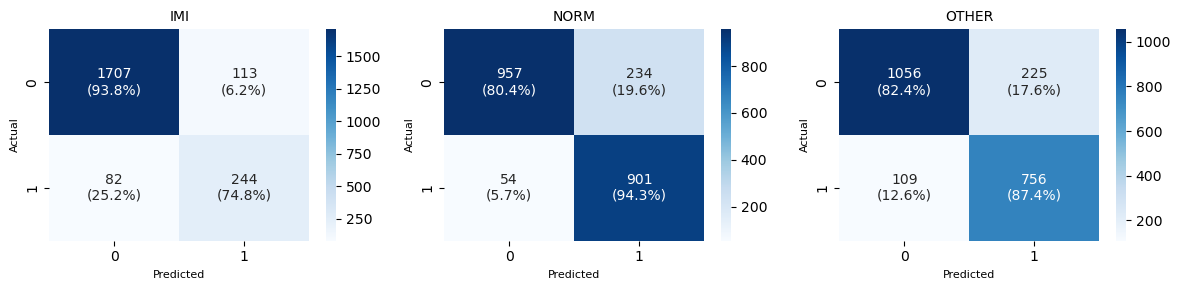

In [165]:
%matplotlib inline

y_val_binary = (y_val > 0.5).astype(int)
y_pred_binary = (y_val_pred > 0.5).astype(int)

# Dynamische Berechnung der Grid-Größe
import math
cols = min(6, num_classes)  # Maximal 6 Spalten
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))

# Flatten axes array für einfacheren Zugriff
if num_classes == 1:
    axes = [axes]
elif rows == 1:
    axes = axes
else:
    axes = axes.flatten()

for i in range(num_classes):
    cm = confusion_matrix(y_val_binary[:, i], y_pred_binary[:, i])
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Kombiniere absolute Zahlen und Prozentzahlen
    labels = np.asarray([f'{v1}\n({v2:.1f}%)' 
                        for v1, v2 in zip(cm.flatten(), cm_percent.flatten())]).reshape(2,2)
    
    sns.heatmap(cm, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(f'{class_names[i]}', fontsize=10)
    axes[i].set_xlabel('Predicted', fontsize=8)
    axes[i].set_ylabel('Actual', fontsize=8)

# Verstecke leere Subplots
for j in range(num_classes, rows * cols):
    if j < len(axes):
        axes[j].set_visible(False)

plt.tight_layout()
plt.show()

^^^
This plot displays binary confusion matrices for each of the 5 superdiagnostic classes (NORM, MI, STTC, CD, HYP). Each heatmap shows true positives, true negatives, false positives, and false negatives for individual classes, helping to identify which classes the model confuses most often.

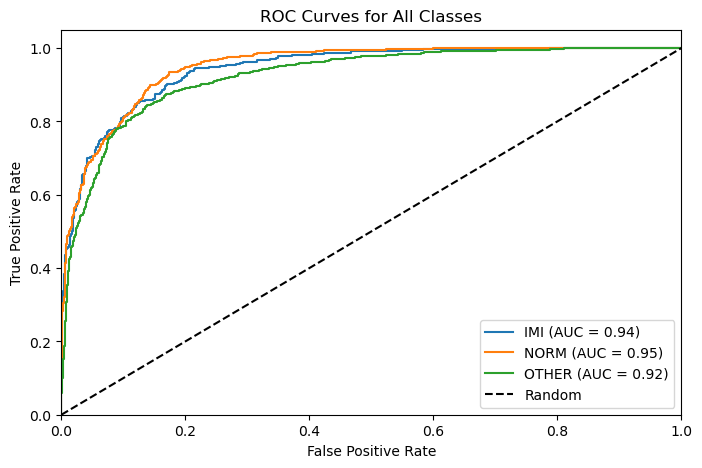

In [163]:
%matplotlib inline

plt.figure(figsize=(8, 5))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Classes')
plt.legend()
plt.show()

^^^This plot shows Receiver Operating Characteristic (ROC) curves for all 5 classes on a single graph. Each curve displays the trade-off between true positive rate and false positive rate at various threshold settings. The Area Under Curve (AUC) values indicate model performance, with values closer to 1.0 being better.

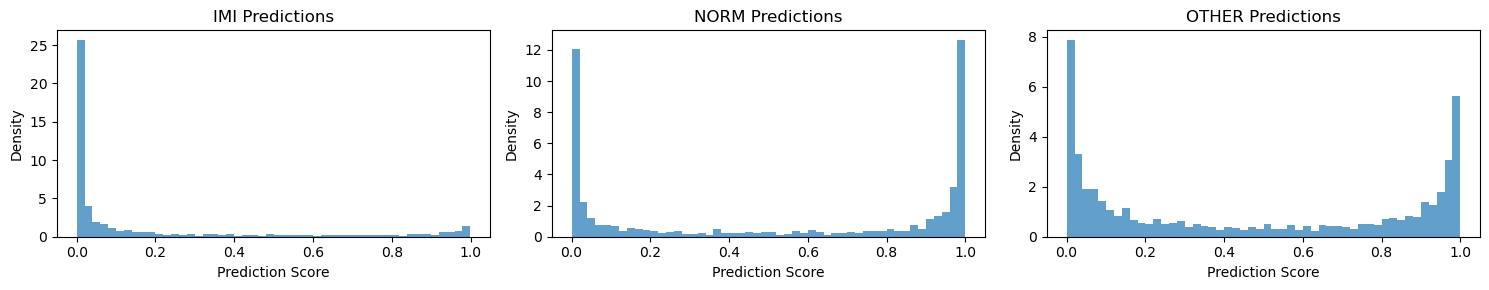

In [164]:
%matplotlib inline
plt.figure(figsize=(15, 3))

for i in range(num_classes):
    plt.subplot(1, num_classes, i+1)
    plt.hist(y_val_pred[:, i], bins=50, alpha=0.7, density=True)
    plt.title(f'{class_names[i]} Predictions')
    plt.xlabel('Prediction Score')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

^^^This plot shows histograms of prediction probability distributions for each class. It visualizes how confident the model is in its predictions - well-separated distributions (peaks near 0 and 1) indicate the model makes confident decisions, while distributions concentrated around 0.5 suggest uncertainty.